In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
output_file = 'results/TimeSelection/results'

total_metrics = pd.read_csv(f'{output_file}.csv')
total_metrics = total_metrics[total_metrics.selection_name != 'SelectionLayer'].reset_index(drop=True)

In [7]:
total_metrics[total_metrics.dataset=="TorneoCO"]

,loss,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,dataset,dataset_name,dataset_params_seq_len,dataset_params_pred_len,dataset_params_select_timesteps,dataset_params_shift,...,model_name,model_params_keep_dims,model_params_type,features,selected_features,duration,history,code,selection_params_threshold,selection_params_regularization
0,0.495238,0.495238,0.585586,95.969727,TorneoCO,TorneoCO,12,1,True,144,...,dense,False,tensorflow,"['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...","['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...",15.460052,"[0.506062388420105, 0.465671181678772, 0.43198...",77950229aec3b3347c5eca61dbc5155f,NaN,NaN
1,0.753065,0.753065,0.750870,110.110321,TorneoCO,TorneoCO,12,1,False,144,...,dense,False,tensorflow,"['target', 'dd', 'no2', 'o3', 'pm10', 'tmp', '...","['target', 'dd', 'no2', 'o3', 'pm10', 'tmp', '...",17.342733,"[1.0280267000198364, 0.9408404231071472, 0.864...",442bdd86230ba1968c933e963701d463,NaN,NaN
2,0.409178,0.409178,0.516383,531.921814,TorneoCO,TorneoCO,24,1,True,144,...,dense,False,tensorflow,"['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...","['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...",15.871252,"[0.5612480640411377, 0.49747905135154724, 0.46...",a802384ad059d66689a43320ff9abfd0,NaN,NaN
3,0.424811,0.424811,0.526136,208.870331,TorneoCO,TorneoCO,24,1,False,144,...,dense,False,tensorflow,"['target', 'dd', 'no2', 'o3', 'pm10', 'tmp', '...","['target', 'dd', 'no2', 'o3', 'pm10', 'tmp', '...",16.954212,"[0.7582045197486877, 0.7526124715805054, 0.749...",76597d947f8043ffc07def059c88e704,NaN,NaN
4,0.495238,0.495238,0.585586,95.969727,TorneoCO,TorneoCO,12,1,True,144,...,dense,False,tensorflow,"['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...","['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...",15.506377,"[0.506062388420105, 0.465671181678772, 0.43198...",77950229aec3b3347c5eca61dbc5155f,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.249516,0.246606,0.416143,74.953491,TorneoCO,TorneoCO,12,1,True,144,...,dense,False,tensorflow,"['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...","['target t-12', 'no2 t-12', 'o3 t-12', 'pm10 t...",24.493407,"[0.38571393489837646, 0.2978016138076782, 0.40...",cbef6728732d9de583b44aff1e330421,NaN,0.00010
80,0.192715,0.178383,0.334375,73.114944,TorneoCO,TorneoCO,12,1,True,144,...,dense,False,tensorflow,"['target t-12', 'dd t-12', 'no2 t-12', 'o3 t-1...","['target t-12', 'no2 t-12', 'o3 t-12', 'tmp t-...",24.036336,"[0.4245569109916687, 0.33062660694122314, 0.40...",6abe574781e0135d94a6cf2a35c44bab,NaN,0.00100
81,0.173965,0.173405,0.333151,297.222382,TorneoCO,TorneoCO,24,1,True,144,...,dense,False,tensorflow,"['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...","['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...",16.391081,"[0.3126945197582245, 0.23501858115196228, 0.27...",651d16293f234c2245fc033c4bf3966c,NaN,0.00001
82,0.129100,0.123932,0.281448,198.499237,TorneoCO,TorneoCO,24,1,True,144,...,dense,False,tensorflow,"['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...","['target t-24', 'dd t-24', 'no2 t-24', 'o3 t-2...",9.942934,"[0.31891900300979614, 0.24006131291389465, 0.2...",763bba1ffa21af3bca08334e6bf1c076,NaN,0.00010


In [3]:
best_metrics = total_metrics.iloc[total_metrics.groupby(['dataset', 'selection_name', 'model_name']).mean_squared_error.idxmin()].reset_index(drop=True)

best_metrics.pivot(values=['mean_absolute_error'], index = ['dataset'], columns=['selection_name' ])

mean_absolute_error                                          \
selection_name         Correlation    Linear MutualInformation NoSelection   
dataset                                                                      
ETTh1                     0.429492  0.429492          0.429492    0.398858   
ETTh2                     0.491660  0.494805          0.491660    0.590137   
Electricity               0.732801  0.732801          0.732801    0.484905   
ExchangeRate              0.530780  0.530780          0.530780    0.644560   
TorneoCO                  0.544274  0.544274          0.544274    0.516383   
TorneoNO2                 0.638790  0.718262          0.627286    0.802149   
TorneoO3                  0.634063  0.690671          0.698730    0.918817   
TorneoPM10                0.845941  0.847636          0.847636    0.597400   
Traffic                   0.497688  0.497688          0.497688    0.358828   

                                   
selection_name TimeSelectionLayer  
dataset                            
ETTh1                    0.077667  
ETTh2                    0.142454  
Electricity              0.416866  
ExchangeRate             0.437046  
TorneoCO                 0.281448  
TorneoNO2                0.423126  
TorneoO3                 0.284389  
TorneoPM10               0.497940  
Traffic                       NaN

In [4]:
def split(a, n):
    k, m = divmod(len(a), n)
    for i in range(n):
        yield k, i, m

# Mejorar y solucionar esto
def plot_selection_maps(total_metrics):

    selected_features = total_metrics.iloc[total_metrics.groupby(['dataset', 'selection_name']).mean_absolute_error.idxmax()].pivot(index='dataset', columns='selection_name', values='selected_features')


    for i, name in enumerate(selected_features.index):
        
        arrays = []
        selected_features.iloc[i] = selected_features.iloc[i].apply(eval)

        original = np.array(selected_features.iloc[i][3])

        division_size = 1 #max(len(original)//51, 1) if len(original) < 100 else 1
        for k, idx, m in split(original, division_size):
            arrays = []
            
            splitted_original = original[idx*k+min(idx, m):(idx+1)*k+min(idx+1, m)] 
            arrays.append(np.isin(splitted_original, splitted_original))
            for j in range(len(selected_features.iloc[i])):
                if j ==3: continue
                
                method = np.array(selected_features.iloc[i][j])
                arrays.append(np.isin(splitted_original, method))
            plt.figure(figsize=(20,10))

            cmap = ListedColormap(cm.get_cmap("Set1")(range(3)))
            plt.imshow(np.array(arrays), cmap=cmap, interpolation="none", aspect="auto")
            plt.yticks([0, 1, 2, 3,4], ['NS', 'Corr', 'Linear', 'MI', 'TSFADL'], fontsize=25)
            plt.xticks([j for j in range(len(splitted_original))], splitted_original[::-1], rotation=90, fontsize=15)
            if len(original) > 100:
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
            plt.title(name, fontsize=25)
            
            plt.savefig(f"results/TimeSelection/maps/Map{name}.png", bbox_inches = 'tight')
    

TypeError: eval() arg 1 must be a string, bytes or code object

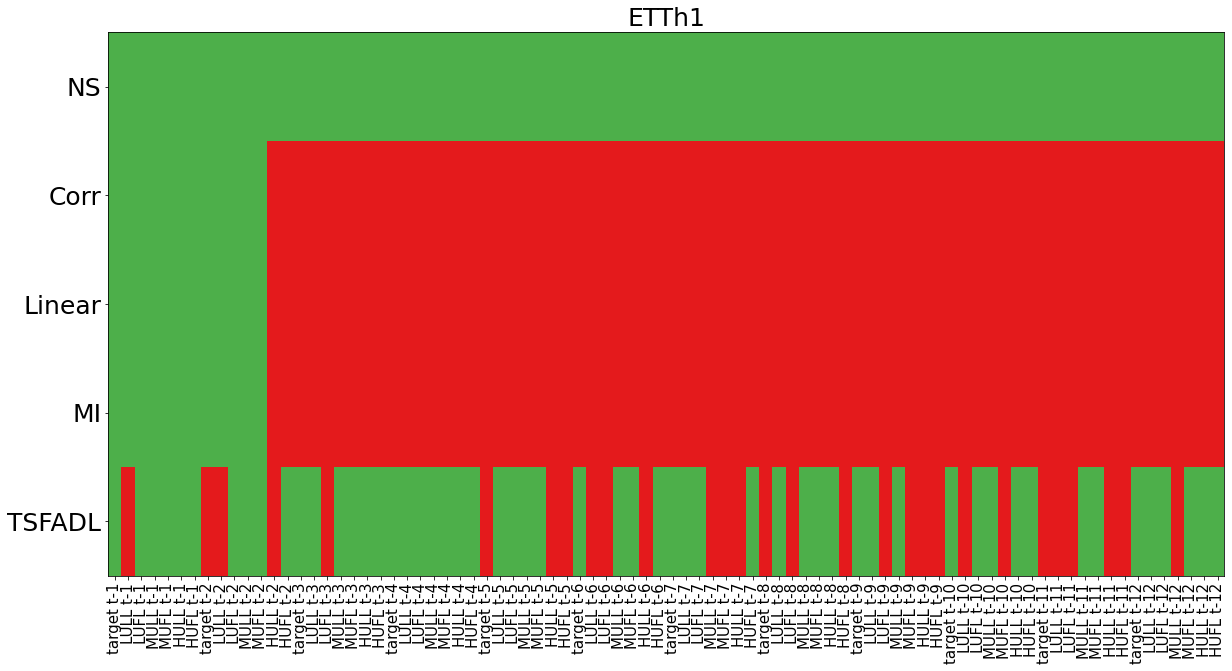

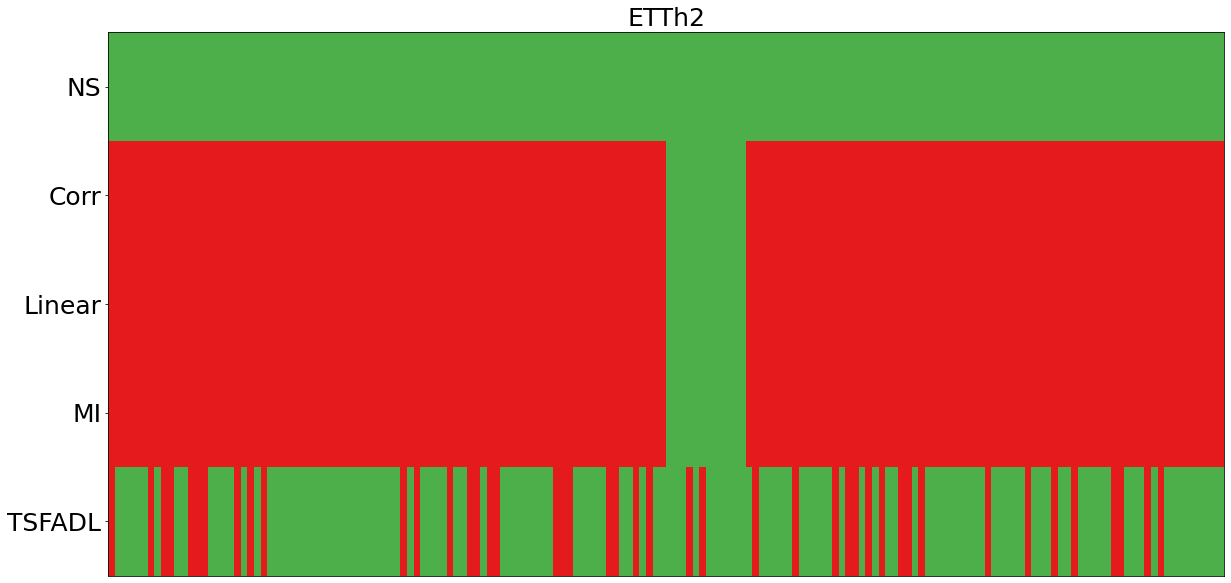

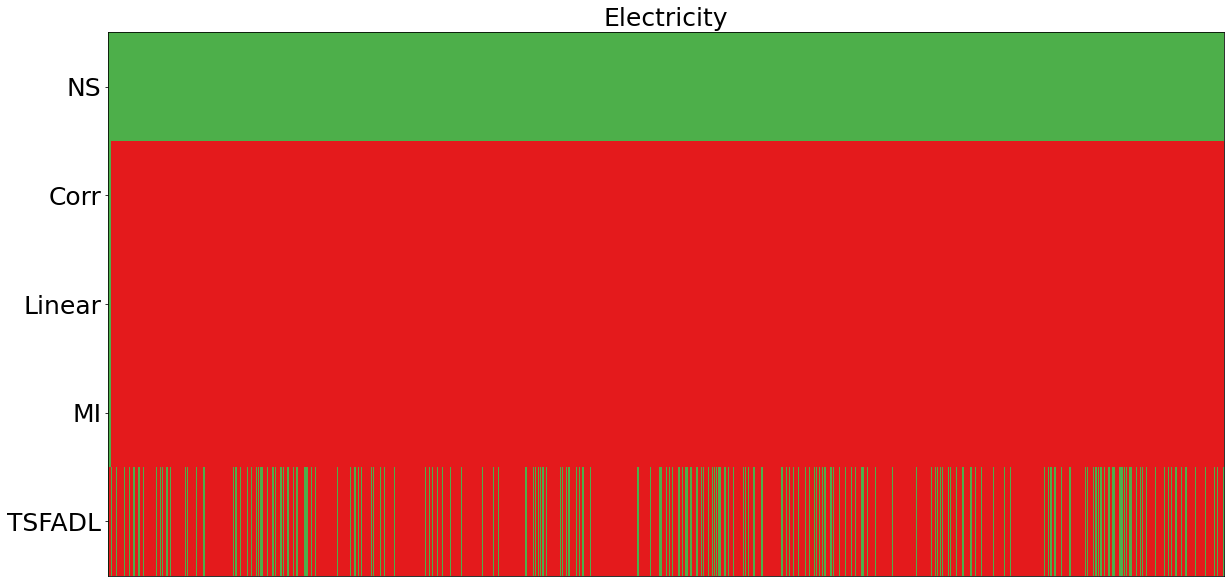

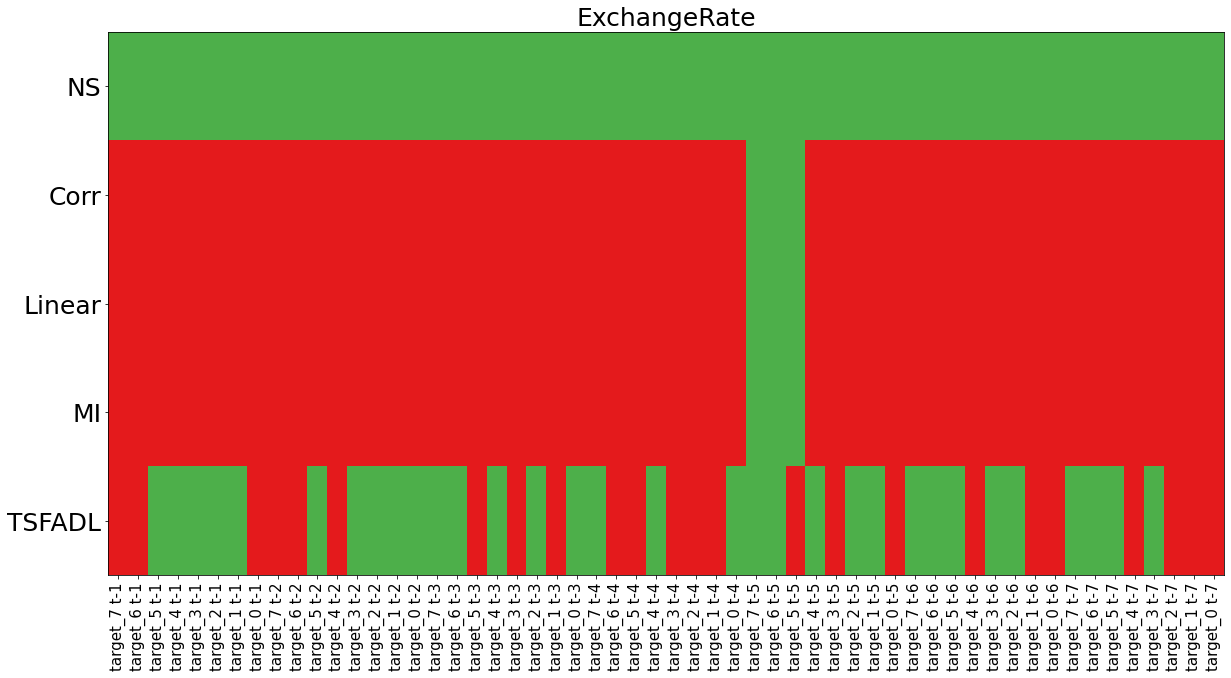

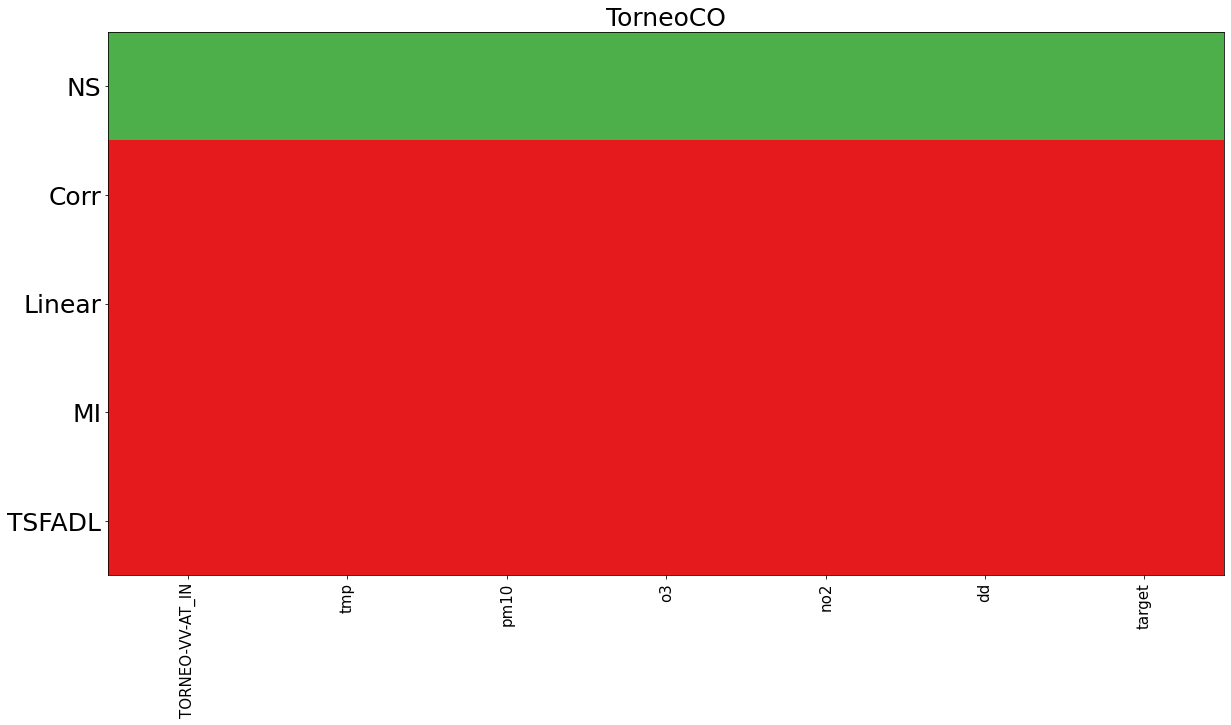

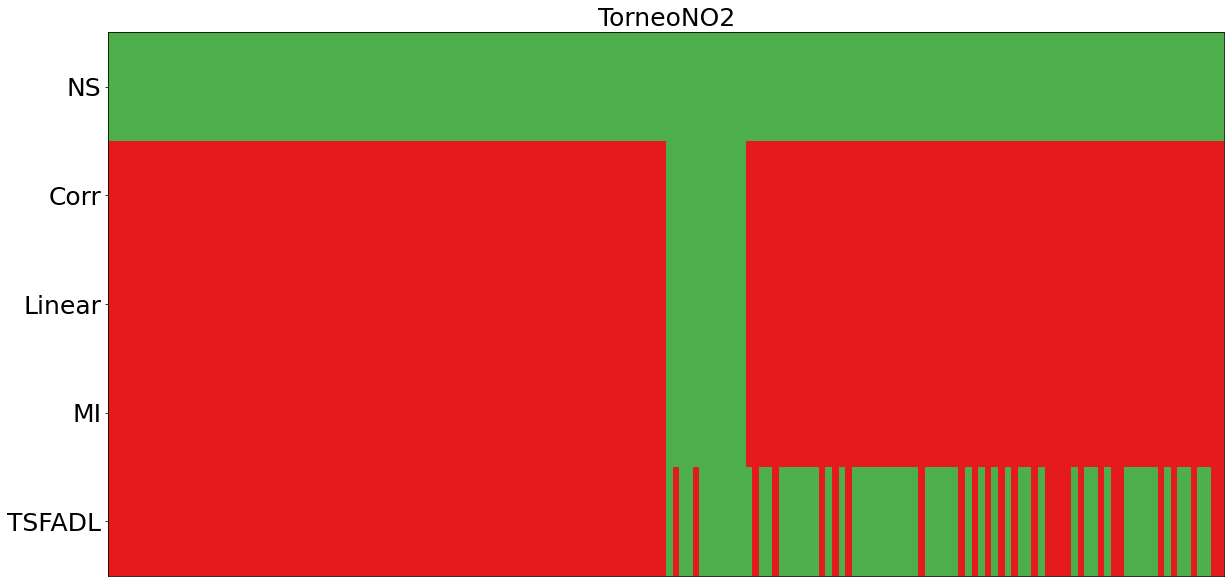

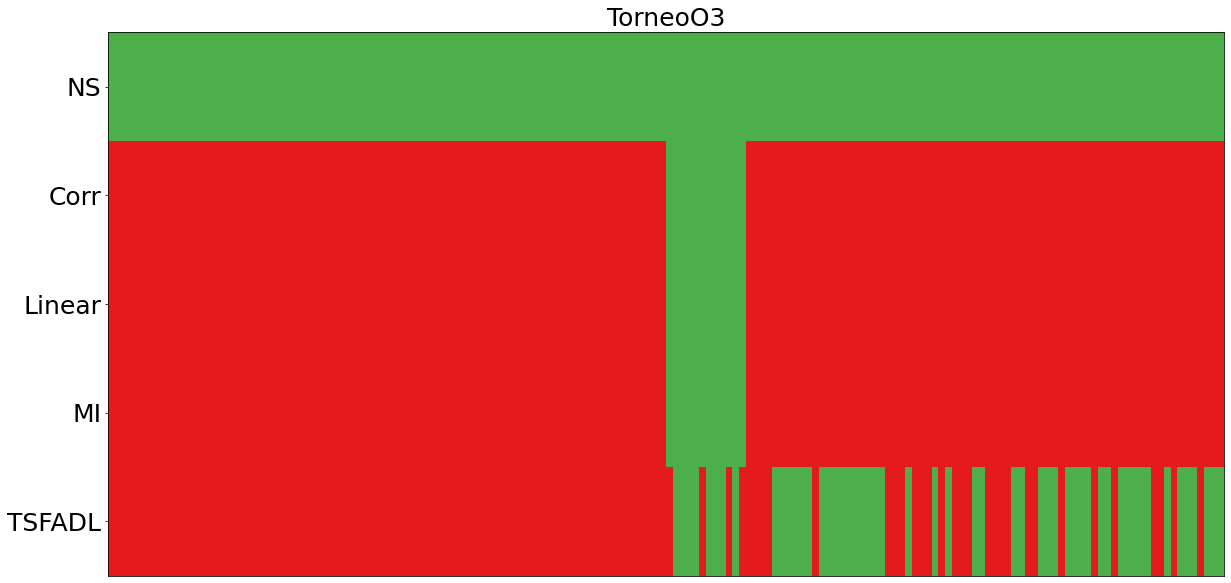

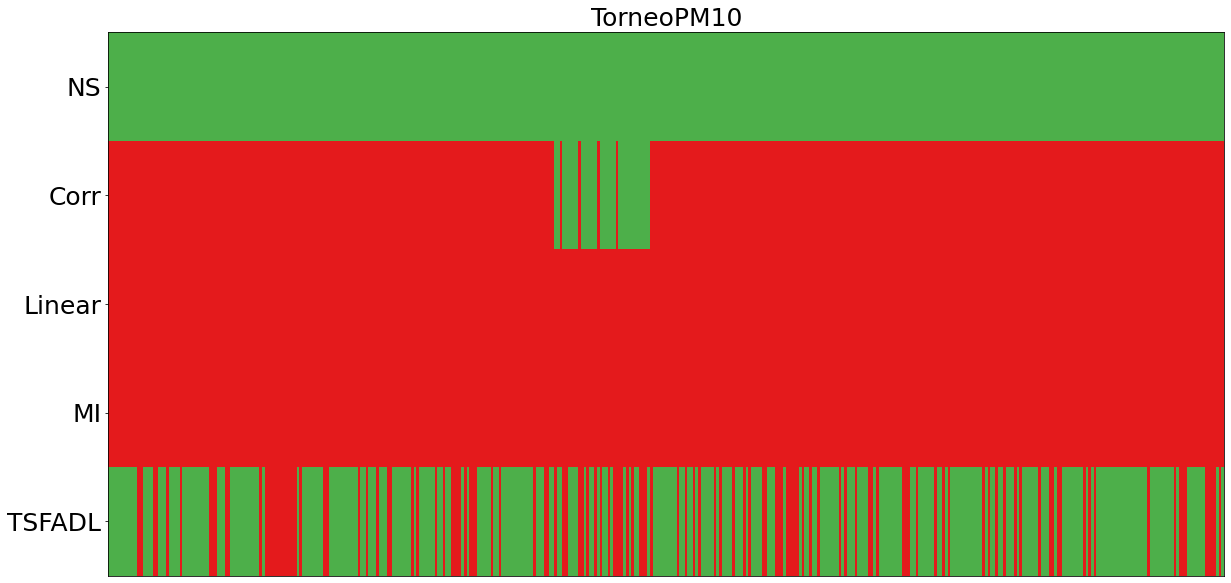

In [5]:
plot_selection_maps(total_metrics)